In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from matplotlib.patches import Ellipse

import numpy as np
from scipy.special import erfcinv
import scipy.stats as st
from scipy.stats import chi2, multivariate_normal, gamma
from scipy.special import erfcinv, erfinv, erf, erfc
from scipy.linalg import sqrtm, inv

import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

import git
import sys, os

# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_global = os.path.dirname(path_git)
print('Path to git repo: {}'.format(path_global))

chi2_val = chi2.ppf(0.6827, df=2)

d = 2
L = 3  # Number of vectors
n_samples = int(1e6)

Path to git repo: /home/matias/Documents/PhD/code


# PTE to $N_{\sigma}$

Que es $N_{\sigma}^{eff}$? Hagamos algunos graficos

In [2]:
import numpy as np
from math import erf, sqrt
from scipy.stats import chi2

def L_iso_from_n(d: int, n: float, sigma2: float = 0.5, gauss_scale: str = '1sigma') -> float:
    """
    Distancia euclídea L entre las medias de dos Gaussianas D-dimensionales
    idénticas e isotrópicas (Sigma = sigma2 * I), tal que sus contornos 
    que en 1D corresponden a ±nσ se 'toquen'.

    Parámetros
    ----------
    d : int
        Dimensión (D).
    n : float
        'Número de sigmas' 1D (es decir, p = erf(n / sqrt(2))).
    sigma2 : float, opcional
        Varianza isotrópica por eje (default 0.5).

    Devuelve
    --------
    L : float
        Distancia euclídea entre medias.
    """


    if gauss_scale == '1sigma':
        # Probabilidad 1D asociada a ±nσ
        p = erf(n / sqrt(2.0)) #is the same, less general
        #p = chi2.cdf(n**2, df=1)  # Cumulative distribution function for chi2Q
    elif gauss_scale == '2sigma':
        p = chi2.cdf(n**2, df=2)  # Cumulative distribution function for chi2

    # Cuantil chi-cuadrado con d grados de libertad
    m2 = chi2.ppf(p, df=d)              # m^2 = χ²_{d,p}
    m  = sqrt(m2)
    # En isotrópico: L = 2 * σ * m, con σ = sqrt(sigma2)
    return 2.0 * sqrt(sigma2) * m

print('--- Using 1sigma scale ---')
for n in [1, 2, 3, 4, 5]:
    print(n, L_iso_from_n(d=2, n=n))   # d=2, sigma^2=0.5

print('--- Using 2sigma scale ---')
for n in [1, 2, 3, 4, 5]:
    print(n, L_iso_from_n(d=2, n=n, gauss_scale='2sigma'))   # d=2, sigma^2=0.5

--- Using 1sigma scale ---
1 2.142778070122352
2 3.515700301858557
3 4.863981513513553
4 6.21834521588094
5 7.5820448992254725
--- Using 2sigma scale ---
1 1.4142135623730951
2 2.8284271247461903
3 4.242640687119287
4 5.656854249492375
5 7.071067811867373


# $N_\sigma^{eff}(N_\sigma)$ and $L(N_\sigma)$

# Three moltivariate distributions

In [3]:
#Sharp triangle
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[1, 0.], [0., 1]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()

In [4]:
#Define some functions:

def calculate_R_CM(vectors):
    num_vectors = len(vectors)
    R_CM = np.sum(vectors, axis=0) / num_vectors
    return R_CM


def construct_C(vectors):
    L = len(vectors)

    K_xx = np.sum((vectors[:, 0]) ** 2)
    K_yy = np.sum((vectors[:, 1]) ** 2)
    K_xy = np.sum((vectors[:, 0]) * (vectors[:, 1]))
    K_yx = K_xy
    C = np.array([[K_xx, K_xy], [K_yx,K_yy]])/L
    return C

def analyzed_lambdas(vectors):
    L = len(vectors)
    C = construct_C(vectors)
    lambdas = np.linalg.eigvals(C)
    mean_lambda = np.sum(lambdas)/L
    std_lambda = np.std(lambdas)
    return mean_lambda, std_lambda

def PTE_2_l(PTE):
    aux = gamma(d,1).isf(PTE) #(beta/L)*
    #l = 2*aux
    l = np.sqrt(aux)
    return l

In [5]:
def Q_tot_quad(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, n_samples, L, H0=False):
    cov_1 = cov_A + cov_B
    cov_2 = cov_A + cov_C
    cov_3 = cov_B + cov_C

    DA = np.random.multivariate_normal(mean_A, cov_A, size=n_samples)
    DB = np.random.multivariate_normal(mean_B, cov_B, size=n_samples)
    DC = np.random.multivariate_normal(mean_C, cov_C, size=n_samples)
    
    # Sampling
    sample_1 = np.dot(sqrtm(np.linalg.inv(cov_1)), np.array(DA-DB).T)  # Shape: (d, n_samples)
    sample_2 = np.dot(sqrtm(np.linalg.inv(cov_2)), np.array(DA-DC).T)  # Shape: (d, n_samples)
    sample_3 = np.dot(sqrtm(np.linalg.inv(cov_3)), np.array(DB-DC).T)  # Shape: (d, n_samples)
    
    if H0==True:
        sample_1_H0 = sample_1 - np.mean(sample_1, axis=1, keepdims=True)
        sample_2_H0 = sample_2 - np.mean(sample_2, axis=1, keepdims=True)
        sample_3_H0 = sample_3 - np.mean(sample_3, axis=1, keepdims=True)
        
        Q = np.zeros(n_samples)
        for i in range(n_samples):
            Q[i] = np.linalg.norm(sample_1_H0[:,i])**2 + np.linalg.norm(sample_2_H0[:,i])**2 + np.linalg.norm(sample_3_H0[:,i])**2       
    else:
        Q = np.zeros(n_samples)
        for i in range(n_samples):
            Q[i] = np.linalg.norm(sample_1[:,i])**2 + np.linalg.norm(sample_2[:,i])**2 + np.linalg.norm(sample_3[:,i])**2

    return Q / L

In [6]:
def plot_geom(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, title, name_plot, png=False, eff_dist=False,
              analytic_tension=False):
    import numpy as np
    from scipy.linalg import sqrtm
    from getdist import plots
    from getdist.mcsamples import MCSamples
    from scipy.special import erfcinv
    from scipy.stats import gamma
    import os
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib import font_manager as fm
    
    # 2) setear la familia correcta y opciones PRL
    mpl.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Nimbus Roman", "Times New Roman", "DejaVu Serif","TeXGyreTermes"],
        "mathtext.fontset": "cm",   # símbolos math tipo Computer Modern
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
    })

    # 3) verificación rápida
    #print("Found:", fm.findfont("TeXGyreTermes"))


    # --- Constantes PRL (una columna) ---
    PRL_COL_W = 3.37  # inches ~ 8.6 cm
    SIZE_LABEL = 9
    SIZE_TICK  = 9
    SIZE_LEG   = 9
    LW         = 0.8  # line width fino PRL
    QUIVER_W   = 0.006  # ancho de flecha (en pulgadas aprox.)

    # ---- Contexto de estilo local (no afecta global) ----
    rc = {
        "font.size": SIZE_TICK,
        "axes.titlesize": SIZE_LABEL,
        "axes.labelsize": SIZE_LABEL,
        "xtick.labelsize": SIZE_TICK,
        "ytick.labelsize": SIZE_TICK,
        "legend.fontsize": SIZE_LEG,
        "lines.linewidth": LW,
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "pdf.fonttype": 42,  # para fuentes embebibles
        "ps.fonttype": 42,
        "font.family": "serif",
        "font.serif": ["TeX Gyre Termes"],
    }

    names  = ['x', 'y']
    labels = ['x', 'y']

    # --- Tensores de tensión r_k ---
    r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
    r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
    r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
    r_4 = - r_1
    r_5 = - r_2
    r_6 = - r_3
    R = np.vstack([r_1, r_2, r_3, r_4, r_5, r_6])

    # --- C_tot y espectro (eigh para simétrica) ---
    C_tot = construct_C(R)
    evals, evecs = np.linalg.eigh(C_tot)
    idx = np.argsort(evals)[::-1]
    lam1, lam2 = evals[idx[0]], evals[idx[1]]
    v1 = evecs[:, idx[0]]
    v2 = evecs[:, idx[1]]

    # --- Métricas / PTE ---
    beta_L = (np.linalg.norm(r_1)**2 + np.linalg.norm(r_2)**2 + np.linalg.norm(r_3)**2) / 3.0
    if not analytic_tension:
        Q_H0 = Q_tot_quad(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, n_samples, 3, H0=True)
        PTE  = (Q_H0 > beta_L).sum() / Q_H0.size
    else:
        PTE  = gamma(d, 1).sf(beta_L)
    n_sigma = np.sqrt(2) * erfcinv(PTE)

    # --- Samples p/ GetDist (triangle) ---
    samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
    samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
    samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)
    chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
    chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
    chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

    dark_violet = '#4B0082'
    colors_tri  = ['#C00000', '#0060C0', '#008040']  # rojo/azul/verde sobrios

    # --- Triangle de GetDist exportado a tamaño PRL ---
    with mpl.rc_context(rc):
        # En 1.6.1 no podemos pasar figure; pero sí controlar el tamaño final exportado
        g = plots.get_subplot_plotter(width_inch=PRL_COL_W, scaling=False)
        g.settings.axes_fontsize   = SIZE_TICK
        g.settings.axes_labelsize  = SIZE_LABEL
        g.settings.legend_fontsize = SIZE_LEG
        g.triangle_plot([chain_A, chain_B, chain_C],
                        filled=True,
                        contour_args={'alpha': 0.5},
                        contour_colors=colors_tri,
                        legend_labels=['A', 'B', 'C'])
        g.add_param_markers({'x': [mean_A[0], mean_B[0], mean_C[0]],
                             'y': [mean_A[1], mean_B[1], mean_C[1]]})
        # Export vector
        if png:
            g.export(f'dist_synth_{name_plot}.png')
        else:
            g.export(f'dist_synth_{name_plot}.pdf')
            g.export(f'dist_synth_{name_plot}.svg')

    # --- Figura geométrica PRL (una columna) ---
    with mpl.rc_context(rc):
        # Altura sugerida ~ (2.3–3.2) in según contenido. Elijo 2.8"
        fig_w, fig_h = PRL_COL_W, 2.8
        fig, ax = plt.subplots(1, 1, figsize=(fig_w, fig_h))

        # Auto-límites + padding
        max_range = np.max(np.abs(R)) if np.isfinite(R).all() else 1.0
        pad = 0.20 * max_range
        lim_x = (-max_range - pad, max_range + pad)
        lim_y = (-max_range - pad, max_range + pad)

        ax.set_xlabel(r'$\Delta \Omega_m$')
        ax.set_ylabel(r'$\Delta H_0$')

        # Tensión en violeta oscuro
        for r in (r_1, r_2, r_3, r_4, r_5, r_6):
            ax.quiver(0, 0, r[0], r[1], angles='xy', scale_units='xy', scale=1,
                      color=dark_violet, width=QUIVER_W, alpha=0.9)

        # Origen y puntas visibles
        ax.scatter([r_1[0], r_2[0], r_3[0]], [r_1[1], r_2[1], r_3[1]],
                   marker='.', color=dark_violet, s=8)
        ax.scatter([0], [0], color='black', s=8)

        # Autovectores en negro (unitarios). Opcional: escalar por sqrt(lam)
        ax.quiver(0, 0, v1[0], v1[1], angles='xy', scale_units='xy', scale=1,
                  color='black', width=QUIVER_W)
        ax.quiver(0, 0, v2[0], v2[1], angles='xy', scale_units='xy', scale=1,
                  color='black', width=QUIVER_W)

        # Etiquetas v1/v2 y de tensiones con offset proporcional
        offset = 0.08 * max_range
        def label_at_vector(ax_, r, text, off, color='black'):
            sx = 1 if r[0] >= 0 else -1
            sy = 1 if r[1] >= 0 else -1
            ax_.text(r[0] + sx * off, r[1] + sy * off, text, size=SIZE_LEG, color=color)

        label_at_vector(ax, v1, 'v1', offset, color='black')
        label_at_vector(ax, v2, 'v2', offset, color='black')

        label_at_vector(ax, r_1, 'AB', offset, color=dark_violet)
        label_at_vector(ax, r_2, 'AC', offset, color=dark_violet)
        label_at_vector(ax, r_3, 'BC', offset, color=dark_violet)
        label_at_vector(ax, r_4, 'BA', offset, color=dark_violet)
        label_at_vector(ax, r_5, 'CA', offset, color=dark_violet)
        label_at_vector(ax, r_6, 'CB', offset, color=dark_violet)

        # --- Recuadro único con autovalores + excentricidad ---
        lam_min = float(np.min(evals))
        lam_max = float(np.max(evals))
        # proteger por si lam_max ~ 0 numéricamente
        ecc = np.sqrt(max(0.0, 1.0 - (lam_min/lam_max if lam_max > 0 else 0.0)))

        info_text = (
            rf"$\lambda_1 = {lam1:.3g}$" "\n"
            rf"$\lambda_2 = {lam2:.3g}$" "\n"
            rf"$\mathrm{{Ecc}} = {ecc:.3g}$"
        )

        ax.text(
            0.98, 0.02, info_text,
            transform=ax.transAxes, ha='right', va='bottom',
            fontsize=SIZE_LEG,
            bbox=dict(boxstyle='round,pad=0.25', facecolor='white',
                    alpha=0.9, edgecolor='black', linewidth=LW)
        )


        ax.set_xlim(*lim_x); ax.set_ylim(*lim_y)
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True, alpha=0.25, linewidth=LW*0.8)

        # Título: PRL suele evitar títulos en la figura; si lo querés, mantenelo corto
        #ax.set_title(title, fontsize=SIZE_LABEL)
        ax.set_title(title, fontsize=10)

        # --- Ajustar tamaño del título automáticamente para que entre ---
        title_obj = ax.set_title(title)
        fig.canvas.draw()  # necesario para obtener el tamaño real

        renderer = fig.canvas.get_renderer()
        bb_title = title_obj.get_window_extent(renderer=renderer)
        bb_ax = ax.get_window_extent(renderer=renderer)

        # Si el título es más ancho que el eje, reducir tamaño
        current_size = SIZE_LABEL
        min_size = 4  # tamaño mínimo permitido

        while bb_title.width > bb_ax.width and current_size > min_size:
            current_size -= 0.5
            title_obj.set_fontsize(current_size)
            fig.canvas.draw()
            bb_title = title_obj.get_window_extent(renderer=renderer)
            bb_ax = ax.get_window_extent(renderer=renderer)
        

        fig.tight_layout(pad=0.02)
        if png:
            fig.savefig(f'geom_{name_plot}_beta.png',
                        dpi=300, bbox_inches='tight')
        else:
            fig.savefig(f'geom_{name_plot}_beta.pdf',
                        bbox_inches='tight')
            fig.savefig(f'geom_{name_plot}_beta.svg',
                        bbox_inches='tight')
        plt.show()

# Real Data

In [7]:
import git
import sys, os

'''
A: CC 
B: Planck18 
C: BAO 
D: PPS
'''

'''
os.chdir(os.path.join(path_global,'montepython_public_old','output'))   

chain_A = getdist.mcsamples.loadMCSamples(file_root='lcdm_cc/2023-09-18_1000000_', no_cache=True,settings={'loglikes':True,'label':'CC','ignore_rows': '0.3'})
chain_B = getdist.mcsamples .loadMCSamples(file_root='lcdm_planck/2023-09-16_1000000_', no_cache=True,settings={'loglikes':True,'label':'Planck18','ignore_rows': '0.3'})
chain_C = getdist.mcsamples.loadMCSamples(file_root='lcdm_bao_plus/2024-03-07_1000000_', no_cache=True,settings={'label':'BAO','ignore_rows': '0.3'})
chain_D = getdist.mcsamples.loadMCSamples(file_root='lcdm_pps/2023-09-18_1000000_', no_cache=True,settings={'label':'PPS','ignore_rows': '0.3'})
'''




os.chdir(os.path.join(path_global,'Cobaya','output','cluster','lcdm'))

chain_A = getdist.mcsamples.loadMCSamples(file_root='lcdm_cc/lcdm_cc', no_cache=True,settings={'loglikes':True,'names':'CC','label':'CC','ignore_rows': '0.3'})
chain_B = getdist.mcsamples.loadMCSamples(file_root='lcdm_planck/lcdm_planck', no_cache=True,settings={'loglikes':True,'names':'Planck18','label':'Planck18','ignore_rows': '0.3'})
chain_C = getdist.mcsamples.loadMCSamples(file_root='lcdm_desi_dr2/lcdm_desi_dr2', no_cache=True,settings={'loglikes':True,'names':'DESI DR2','label':'DESI DR2','ignore_rows': '0.3'})
chain_D = getdist.mcsamples.loadMCSamples(file_root='lcdm_pps/lcdm_pps', no_cache=True,settings={'names':'PPS','label':'PPS','ignore_rows': '0.3'})



param_names = ['Omega_m','H0'] #Shared paameters
names = param_names
labels = ['\Omega_m','H_0']

#Estimate the mean and covariance of the chains:
mean_A_0 = chain_A.mean(param_names)
mean_B_0 = chain_B.mean(param_names)
mean_C_0 = chain_C.mean(param_names)
mean_D_0 = chain_D.mean(param_names)

cov_A_0 = chain_A.cov(param_names)
cov_B_0 = chain_B.cov(param_names)
cov_C_0 = chain_C.cov(param_names)
cov_D_0 = chain_D.cov(param_names)

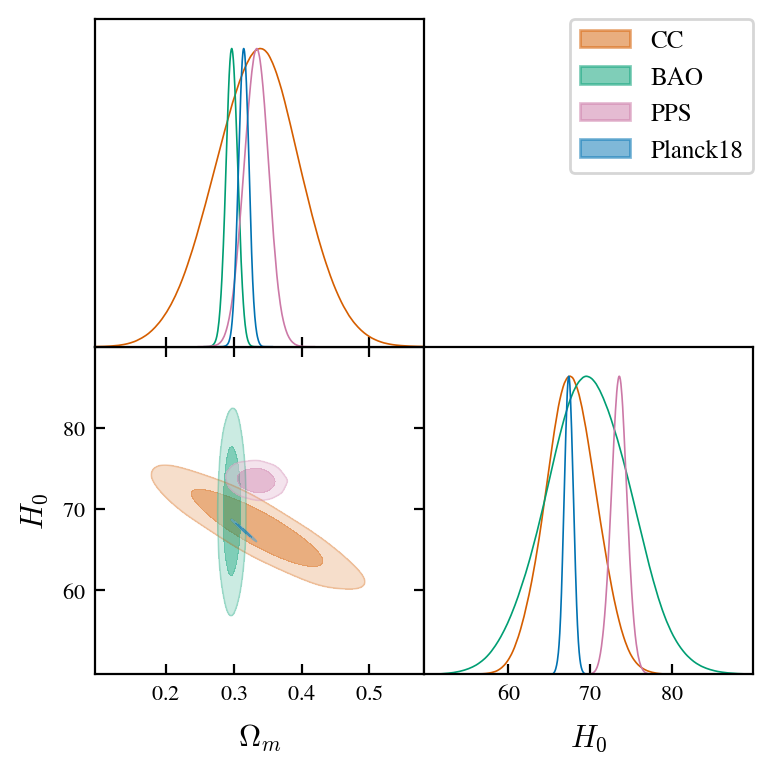

In [8]:
samps_A = np.random.multivariate_normal(mean_A_0, cov_A_0, size=10000)
samps_B = np.random.multivariate_normal(mean_B_0, cov_B_0, size=10000)
samps_C = np.random.multivariate_normal(mean_C_0, cov_C_0, size=10000)
samps_D = np.random.multivariate_normal(mean_D_0, cov_D_0, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')
chain_D = MCSamples(samples=samps_D, names=names, labels=labels, label='Dataset D')


colors = [
    '#D55E00',  # naranja oscuro  → altísimo contraste
    '#009E73',  # verde/turquesa  → gran contraste con naranja y púrpura
    '#CC79A7',   # magenta suave pero muy distinguible
    '#0072B2'  # azul puro (no violáceo; colorblind-safe)
]


g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_C, chain_D, chain_B],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['CC', 'BAO', 'PPS', 'Planck18'],
                labels=[r'$\Omega_m$', r'$H_0$'])

g.export(os.path.join(path_global, 'dist_data_tot.pdf'))
g.export(os.path.join(path_global, 'dist_data_tot.svg'))
plt.show()